In [2]:
import gymnasium as gym
import numpy as np
from itertools import count
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
# Developed by E.T Jaba Jasphin
# Saveetha Engineering College

In [3]:
!pip install pygame

In [4]:
!pip install gymnasium
!pip install gymnasium[box2d]
!pip install jupyterlab
!pip install tqdm

  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py: started
  Running setup.py install for box2d-py: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [28 lines of output]
  Using setuptools (version 63.4.1).
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-39
  creating build\lib.win-amd64-cpython-39\Box2D
  copying library\Box2D\Box2D.py -> build\lib.win-amd64-cpython-39\Box2D
  copying library\Box2D\__init__.py -> build\lib.win-amd64-cpython-39\Box2D
  creating build\lib.win-amd64-cpython-39\Box2D\b2
  copying library\Box2D\b2\__init__.py -> build\lib.win-amd64-cpython-39\Box2D\b2
  running build_ext
  building 'Box2D._Box2D' extension
  swigging Box2D\Box2D.i to Box2D\Box2D_wrap.cpp
  swig.exe -python -c++ -IBox2D -small -O -includeall -ignoremissing -w201 -globals b2Globals -outdir library\Box2D -keyword -w511 -D_SWIG_KWARGS -o Box2D\Box2D_wrap.cpp Box2D\Box2D.i
  Box2D\Common\b2Math.h(67) : Warning 302: Redefinition of identifier 'b2Vec2' by %extend 

In [5]:
g_bins = 10
Q_track = 0
Q = 0

In [6]:
def create_bins(n_bins=g_bins, n_dim=4):

    bins = [
        np.linspace(-4.8, 4.8, n_bins),
        np.linspace(-4, 4, n_bins),
        np.linspace(-0.418, 0.418, n_bins),
        np.linspace(-4, 4, n_bins)
    ]

    return bins

In [7]:
def discretize_state(observation, bins):

    binned_state = []

    for i in range(len(observation)):
        d = np.digitize(observation[i], bins[i])
        binned_state.append( d - 1)

    return tuple(binned_state)

In [8]:
def decay_schedule(
    init_value, min_value, decay_ratio,
    max_steps, log_start = -2, log_base=10):
    decay_steps = int(max_steps*decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(
      log_start, 0, decay_steps,
      base = log_base, endpoint = True)[::-1]
    values = (values -values.min())/(values.max() - values.min())
    values = (init_value - min_value)*values +min_value
    values = np.pad(values, (0, rem_steps), 'edge')

    return values

In [9]:
def generate_trajectory(
    select_action, Q, epsilon,
    env, max_steps=200):
    done, trajectory = False, []
    bins = create_bins(g_bins)
    
    observation,_ = env.reset()
    state = discretize_state(observation, bins)
    
    for t in count():
        action = select_action(state, Q, epsilon)
        observation, reward, done, _, _ = env.step(action)
        next_state = discretize_state(observation, bins)
        if not done:                
            if t >= max_steps-1:
                break
            experience = (state, action,
                    reward, next_state, done)                            
            trajectory.append(experience)                
        else:
            experience = (state, action,
                    -100, next_state, done)
            trajectory.append(experience)                
            #time.sleep(2)
            break
        state = next_state

    return np.array(trajectory, dtype=object)

In [10]:
def mc_control (env,n_bins=g_bins, gamma = 1.0,
                init_alpha = 0.5,min_alpha = 0.01, alpha_decay_ratio = 0.5,
                init_epsilon = 1.0, min_epsilon = 0.1, epsilon_decay_ratio = 0.9,
                n_episodes = 3000, max_steps = 200, first_visit = True, init_Q=None):
    
    nA = env.action_space.n
    discounts = np.logspace(0, max_steps,
                            num = max_steps, base = gamma,
                            endpoint = False)
    alphas = decay_schedule(init_alpha, min_alpha,
                            0.9999, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon,
                            0.99, n_episodes)
    pi_track = []
    global Q_track
    global Q
    
    
    if init_Q is None:
        Q = np.zeros([n_bins]*env.observation_space.shape[0] + [env.action_space.n],dtype =np.float64)
    else:
        Q = init_Q
        
    n_elements = Q.size
    n_nonzero_elements = 0
    
    Q_track = np.zeros([n_episodes] + [n_bins]*env.observation_space.shape[0] + [env.action_space.n],dtype =np.float64)
    select_action = lambda state, Q, epsilon: np.argmax(Q[tuple(state)]) if np.random.random() > epsilon else np.random.randint(len(Q[tuple(state)]))

    progress_bar = tqdm(range(n_episodes), leave=False)
    steps_balanced_total = 1
    mean_steps_balanced = 0
    for e in progress_bar:        
        trajectory = generate_trajectory(select_action, Q, epsilons[e],
                                    env, max_steps)
        
        steps_balanced_total = steps_balanced_total + len(trajectory)
        mean_steps_balanced = 0
        
        visited = np.zeros([n_bins]*env.observation_space.shape[0] + [env.action_space.n],dtype =np.float64)
        for t, (state, action, reward, _, _) in enumerate(trajectory):
            #if visited[tuple(state)][action] and first_visit:
            #    continue    
            visited[tuple(state)][action] = True
            n_steps = len(trajectory[t:])
            G = np.sum(discounts[:n_steps]*trajectory[t:, 2])
            Q[tuple(state)][action] = Q[tuple(state)][action]+alphas[e]*(G - Q[tuple(state)][action])
        Q_track[e] = Q
        n_nonzero_elements = np.count_nonzero(Q)
        pi_track.append(np.argmax(Q, axis=env.observation_space.shape[0]))
        if e != 0:
            mean_steps_balanced = steps_balanced_total/e
        #progress_bar.set_postfix(episode=e, Epsilon=epsilons[e], Steps=f"{len(trajectory)}" ,MeanStepsBalanced=f"{mean_steps_balanced:.2f}", NonZeroValues="{0}/{1}".format(n_nonzero_elements,n_elements))
        progress_bar.set_postfix(episode=e, Epsilon=epsilons[e], StepsBalanced=f"{len(trajectory)}" ,MeanStepsBalanced=f"{mean_steps_balanced:.2f}")
        
    print("mean_steps_balanced={0},steps_balanced_total={1}".format(mean_steps_balanced,steps_balanced_total))
    V = np.max(Q, axis=env.observation_space.shape[0])
    pi = lambda s:{s:a for s, a in enumerate(np.argmax(Q, axis=env.observation_space.shape[0]))}[s]

    return Q, V, pi

In [11]:
env = gym.make("CartPole-v1", render_mode="human")
observation, info = env.reset(seed=42)

In [31]:
#To load the action value function
Q = np.load("state_action_values.npy")

In [32]:
#To save the action value function
np.save("state_action_values.npy", Q)

In [14]:
observation, info = env.reset(seed=42)

In [15]:
observation, reward, done, _, _ = env.step(1)
print(done)

False


In [16]:
observation

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

In [17]:
env.action_space.n

2

In [18]:
# To run the MC control without using the previous Q values
optimal_Q, optimal_V, optimal_pi = mc_control (env,n_episodes=200)

mean_steps_balanced=68.57286432160804,steps_balanced_total=13646


In [19]:
# To run the MC control using the previous Q values and default parameters
optimal_Q, optimal_V, optimal_pi = mc_control (env,n_episodes=200,
                                    init_alpha = 0.5,min_alpha = 0.01, alpha_decay_ratio = 0.5,
                                    init_epsilon = 1.0, min_epsilon = 0.1, epsilon_decay_ratio = 0.9,                                               
                                    max_steps=500, init_Q=Q)

mean_steps_balanced=116.98492462311557,steps_balanced_total=23280


In [26]:
# To run the MC control using the previous Q values and modified parameters
optimal_Q, optimal_V, optimal_pi = mc_control (env,n_episodes=500,
                                    init_alpha = 0.01,min_alpha = 0.005, alpha_decay_ratio = 0.5,
                                    init_epsilon = 0.1 , min_epsilon = 0.08, epsilon_decay_ratio = 0.9,                                               
                                    max_steps=500, init_Q=Q)

mean_steps_balanced=278.0180360721443,steps_balanced_total=138731


In [21]:
np.count_nonzero(Q)

541

In [22]:
np.size(Q)

20000

In [23]:
ep1 = decay_schedule(1, 0.1, 0.99, 50)

In [24]:
x = np.arange(0,50)

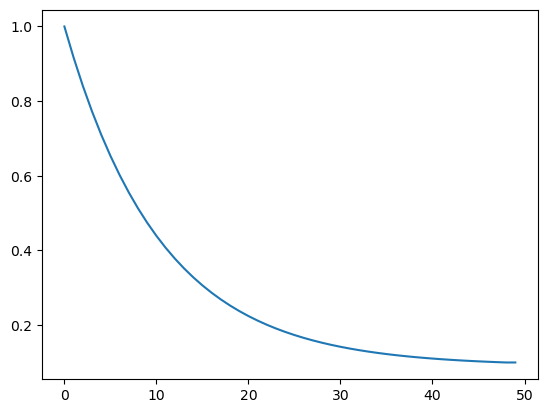

In [25]:
plt.plot(x,ep1,label='ep1')